In [1]:
import importlib as imp
import spotiphy
import numpy as np
import scanpy as sc
import squidpy as sq
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import spotiphy
import seaborn as sns

In [2]:
adata_st = sc.read_h5ad("results/Xenium/adata_st.h5ad")
adata_st.uns['spatial']['NCF221-D']['scalefactors']['tissue_hires_crop_scalef'] = 0.2
type_list = adata_st.uns['type_list']
results_folder = 'results/Xenium/evaluation/'
data_folder = 'results/Xenium/evaluation/deconvolution/'
type_list_RCTD = [s.replace('/', '') for s in type_list]
type_list_RCTD = [s.replace(' ', '.') for s in type_list_RCTD]
cell_count_truth = adata_st.obs[type_list].to_numpy()
selected_spot = np.sum(cell_count_truth, axis=1)>0
proportion_truth = cell_count_truth[selected_spot]/np.sum(cell_count_truth[selected_spot], axis=1,
                                                          keepdims=True)

In [3]:
proportion_spotiphy = np.load(data_folder+'proportion_Sp.npy')
proportion_tangram = np.load(data_folder+'proportion_Tg.npy')
proportion_c2l = np.load(data_folder+'proportion_c2l.npy')
proportion_CARD = pd.read_csv(data_folder+'Proportion_CARD.csv', index_col=0, header=0)
proportion_CARD = proportion_CARD.reindex(adata_st.obs_names)
proportion_CARD = proportion_CARD[type_list].values
proportion_CARD[np.isnan(proportion_CARD)] = 1/proportion_CARD.shape[1]
proportion_cyto = pd.read_csv(data_folder+'Proportion_Cyto.csv', index_col=0, header=0)
proportion_cyto = proportion_cyto.reindex(adata_st.obs_names)
proportion_cyto = proportion_cyto[type_list].values
proportion_RCTD = pd.read_csv(data_folder+'Proportion_RCTD.csv', index_col=0, header=0)
proportion_RCTD = proportion_RCTD.reindex(adata_st.obs_names)
proportion_RCTD = proportion_RCTD[type_list_RCTD].values

methods = ['Spotiphy', 'Cell2location', 'CytoSPACE', 'CARD', 'Tangram', 'RCTD']
proportion_estimated = [proportion_spotiphy, proportion_c2l, proportion_cyto, proportion_CARD, proportion_tangram,
                        proportion_RCTD]
proportion_estimated = [p[selected_spot] for p in proportion_estimated]
proportion_dict = {k:v for k, v in zip(methods, proportion_estimated)}
adata_st = adata_st[selected_spot]

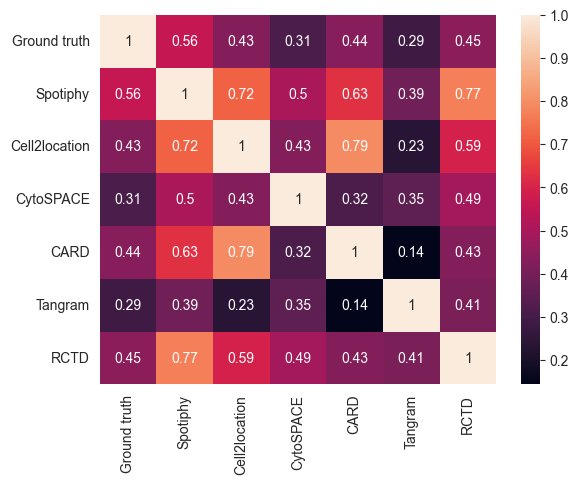

In [4]:
proportion_agg = [proportion_truth.flatten()] + [proportion.flatten() for proportion in proportion_estimated]
proportion_agg = np.vstack(proportion_agg)
corr_matrix = np.corrcoef(proportion_agg)
plt.grid(False)
sns.heatmap(corr_matrix, xticklabels=['Ground truth']+methods, yticklabels=['Ground truth']+methods, annot=True)
plt.savefig(results_folder+'correlation_all', dpi=400, bbox_inches = 'tight')

In [29]:
imp.reload(spotiphy.deconvolution)

<module 'spotiphy.deconvolution' from 'C:\\Users\\zzheng92\\Desktop\\Spotiphy\\spotiphy\\deconvolution.py'>

In [23]:
Eval = spotiphy.deconvolution.Evaluation(proportion_truth, proportion_estimated, methods, out_dir=results_folder, type_list=type_list)
metrics = ['Cosine similarity', 'Absolute error', 'Square error', 'Correlation', 'Fraction of cells correctly mapped',
           'JSD']
for metric in metrics:
    Eval.plot_metric(save=True, metric=metric, metric_type='Spot')
    Eval.plot_metric(save=True, metric=metric, metric_type='Cell type')

In [ ]:
cell_type_group = ['L2/3 IT CTX', 'L4 IT CTX', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX', 'L5/6 IT CTX', 'L5/6 NP CTX', 'L6 CT CTX',
                   'L6 IT CTX', 'L6b CTX']
for metric in metrics:
    Eval.plot_metric(save=True, metric=metric, metric_type='Cell type', cell_types=cell_type_group, suffix='group1')

In [ ]:
for i, cell_type in enumerate(type_list):
    proportion_agg = [proportion_truth[:, i]+1e-8] + [proportion[:, i]+1e-8 for proportion in proportion_estimated]
    proportion_agg = np.vstack(proportion_agg)
    corr_matrix = np.corrcoef(proportion_agg)
    plt.figure(figsize=(7, 6))
    plt.grid(False)
    plt.title(cell_type)
    sns.heatmap(corr_matrix, xticklabels=['Ground truth']+methods, yticklabels=['Ground truth']+methods, annot=True)
    cell_type = "".join(x for x in cell_type if x.isalnum())
    plt.savefig(results_folder+'extra figures/correlation_'+cell_type+'.png', dpi=400, bbox_inches = 'tight')

In [ ]:
type_list_truth = [type +'_truth' for type in type_list]
adata_st.obs[type_list_truth] = proportion_truth
type_list_method = []
for method in methods:
    type_list_method.append([type +'_' + method for type in type_list])
    adata_st.obs[type_list_method[-1]] = proportion_dict[method]

In [5]:
%matplotlib agg
%matplotlib agg
with mpl.rc_context({'figure.figsize': [5, 5], 'figure.dpi': 800}):
    for j, method in enumerate(methods):
        vmax = np.quantile(adata_st.obs[type_list_method[j]].to_numpy(), 0.98, axis=0)
        vmax[vmax < 0.05] = 0.05
        for i, cell_type in enumerate(type_list):
            ax = sc.pl.spatial(adata_st, cmap='magma', color=cell_type+'_'+method, img_key='hires', vmin=0, vmax=vmax[i],
                               size=1.3, show=False)
            cell_type = "".join(x for x in cell_type if x.isalnum())
            ax[0].get_figure().savefig(results_folder+'individual/'+method+'/'+cell_type+'.jpg')

scatterplots.py (242): More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


In [8]:
vmax = np.quantile(adata_st.obs[type_list_truth].to_numpy(), 0.98, axis=0)
vmax[vmax < 0.05] = 0.05
with mpl.rc_context({'figure.figsize': [5, 5], 'figure.dpi': 800}):
    for i, cell_type in enumerate(type_list_truth):
        ax = sc.pl.spatial(adata_st, cmap='magma', color=cell_type, img_key='hires', vmin=0, vmax=vmax[i], size=1.3, show=False)
        cell_type = "".join(x for x in cell_type if x.isalnum())
        ax[0].get_figure().savefig(results_folder+'individual/truth/'+cell_type+'.jpg')

In [6]:
celltype_group = [['L2/3 IT CTX', 'L4 IT CTX', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX', 'L5/6 IT CTX', 'L5/6 NP CTX',
                   'L6 CT CTX', 'L6 IT CTX', 'L6b CTX', 'CA', 'DG', 'SUB', 'Pvalb', 'Lamp5'],
                  ['Astro', 'Oligo'],
                  ['Microglia']]
idx = 0
celltype_select = celltype_group[idx]
celltype_idx = np.array([list(type_list).index(cell_type) for cell_type in celltype_select])

([<matplotlib.axis.XTick at 0x2729b1e7d30>,
 [Text(0, 0, 'Astro'),
  Text(1, 0, 'BCell'),
  Text(2, 0, 'CA'),
  Text(3, 0, 'DG'),
  Text(4, 0, 'Endo'),
  Text(5, 0, 'L2/3 IT CTX'),
  Text(6, 0, 'L4 IT CTX'),
  Text(7, 0, 'L4/5 IT CTX'),
  Text(8, 0, 'L5 IT CTX'),
  Text(9, 0, 'L5 PT CTX'),
  Text(10, 0, 'L5/6 IT CTX'),
  Text(11, 0, 'L5/6 NP CTX'),
  Text(12, 0, 'L6 CT CTX'),
  Text(13, 0, 'L6 IT CTX'),
  Text(14, 0, 'L6b CTX'),
  Text(15, 0, 'Lamp5'),
  Text(16, 0, 'Macrophage'),
  Text(17, 0, 'Microglia'),
  Text(18, 0, 'Neutrophil'),
  Text(19, 0, 'Oligo'),
  Text(20, 0, 'Pvalb'),
  Text(21, 0, 'SUB'),
  Text(22, 0, 'Sncg'),
  Text(23, 0, 'Sst'),
  Text(24, 0, 'Sst Chodl'),
  Text(25, 0, 'TCell'),
  Text(26, 0, 'Vip')])

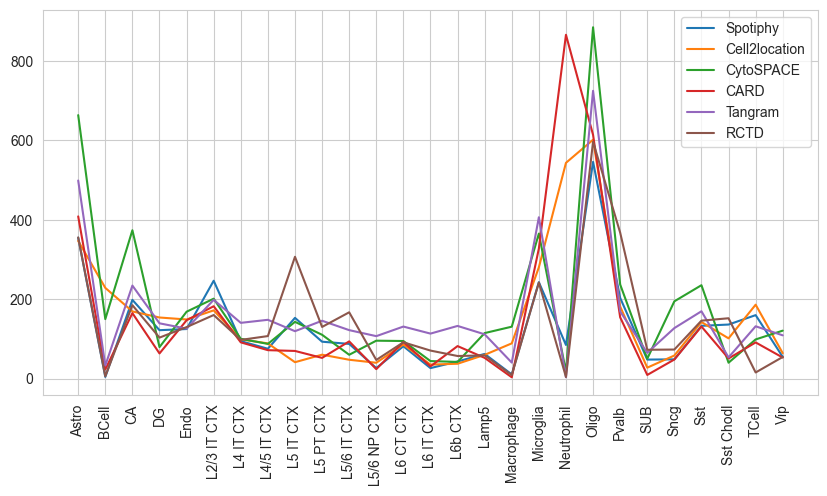

In [10]:
plt.figure(figsize=(10, 5))
for i, method in enumerate(methods):
    plt.plot(Eval.metric_dict['Absolute error Cell type'][i])
plt.legend(methods)
plt.xticks(np.arange(len(type_list)), type_list, rotation=90)

([<matplotlib.axis.XTick at 0x2729b3d5c40>,
 [Text(0, 0, 'Astro'),
  Text(1, 0, 'BCell'),
  Text(2, 0, 'CA'),
  Text(3, 0, 'DG'),
  Text(4, 0, 'Endo'),
  Text(5, 0, 'L2/3 IT CTX'),
  Text(6, 0, 'L4 IT CTX'),
  Text(7, 0, 'L4/5 IT CTX'),
  Text(8, 0, 'L5 IT CTX'),
  Text(9, 0, 'L5 PT CTX'),
  Text(10, 0, 'L5/6 IT CTX'),
  Text(11, 0, 'L5/6 NP CTX'),
  Text(12, 0, 'L6 CT CTX'),
  Text(13, 0, 'L6 IT CTX'),
  Text(14, 0, 'L6b CTX'),
  Text(15, 0, 'Lamp5'),
  Text(16, 0, 'Macrophage'),
  Text(17, 0, 'Microglia'),
  Text(18, 0, 'Neutrophil'),
  Text(19, 0, 'Oligo'),
  Text(20, 0, 'Pvalb'),
  Text(21, 0, 'SUB'),
  Text(22, 0, 'Sncg'),
  Text(23, 0, 'Sst'),
  Text(24, 0, 'Sst Chodl'),
  Text(25, 0, 'TCell'),
  Text(26, 0, 'Vip')])

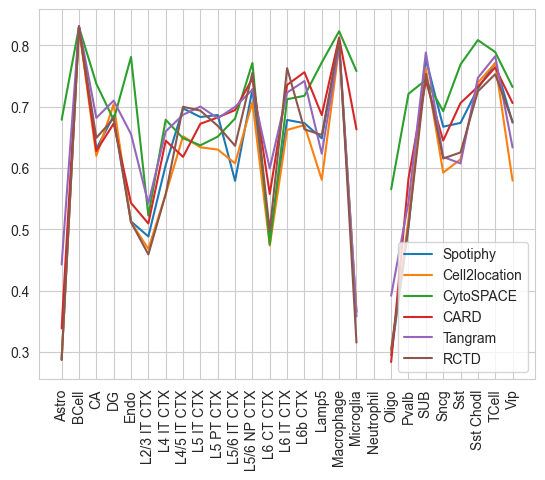

In [11]:
for i, method in enumerate(methods):
    plt.plot(Eval.metric_dict['JSD Cell type'][i])
plt.legend(methods)
plt.xticks(np.arange(len(type_list)), type_list, rotation=90)